Time series, tomato price predicted with random forest:


In [27]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, PolynomialFeatures
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve




In [2]:
# Load data
data = pd.read_csv("data/all_data.csv")
data.head(3)


,day,temperature_max,temperature_min,humidity,precip_intensity,precip_intensity_max,pressure,visibility,wind_speed,oil_price,lettuce_price,onion_price,tomato_price
0,2015-01-31 00:00:00+00:00,0.86,0.22,0.866429,2.21,2.45,101.42,450.37,0.55,31.509143,0.3320,0.3620,0.3900
1,2015-02-28 00:00:00+00:00,0.80,0.19,0.842143,0.01,0.02,101.66,559.40,0.42,33.266871,0.3325,0.3325,0.3325
2,2015-03-31 00:00:00+00:00,1.12,0.38,0.791875,0.00,0.02,102.05,487.51,0.49,31.995306,0.3225,0.7225,1.1600


In [3]:
# I check the shape
data.shape

(60, 13)

In [4]:
# round and reemplace missing values for mean
data = data.round(2)
data = data.fillna(value=round(data.mean(), 2))


Text(0.5, 0, 'Tomato price feature')

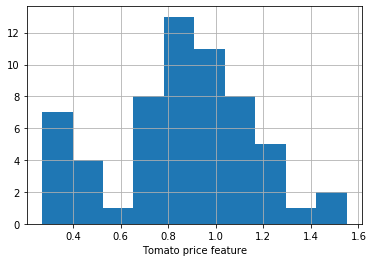

In [5]:
# Display histogram of the price scores
data['tomato_price'].hist()
plt.xlabel('Tomato price feature')

In [6]:
# the histogram seems to be unbalanced


In [7]:
# I build a function to balance the tomato_price column

def transform(col):
    col = round(col, 2)
    if col < 0.89:
        return -1
    elif col > 0.89:
        return 1
    else: 
        return 0
data['tomato_price'] = data['tomato_price'].apply(transform)

data.tomato_price.value_counts()

-1    33
 1    27
Name: tomato_price, dtype: int64

Text(0.5, 0, 'Tomato price feature')

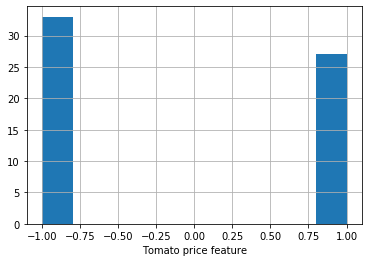

In [8]:

data['tomato_price'].hist()
plt.xlabel('Tomato price feature')


In [9]:
# the histogram seems balanced

In [10]:
# I split the column of the day into days, months and years and add to the dataset
data["day"] = pd.to_datetime(data["day"])
data["years"] = data["day"].dt.year
data["months"] = data["day"].dt.month
data["days"] = data["day"].dt.day
del data["day"]
data.head(3)

,temperature_max,temperature_min,humidity,precip_intensity,precip_intensity_max,pressure,visibility,wind_speed,oil_price,lettuce_price,onion_price,tomato_price,year,month,days
0,0.86,0.22,0.87,2.21,2.45,101.42,450.37,0.55,31.51,0.33,0.36,-1,2015,1,31
1,0.80,0.19,0.84,0.01,0.02,101.66,559.40,0.42,33.27,0.33,0.33,-1,2015,2,28
2,1.12,0.38,0.79,0.00,0.02,102.05,487.51,0.49,32.00,0.32,0.72,1,2015,3,31


In [11]:

# I Scale/Normalize the numerical values

num_features = ['temperature_max', 'temperature_min', 'humidity',
       'precip_intensity', 'precip_intensity_max', 'pressure', 'visibility',
       'wind_speed', 'oil_price', 'lettuce_price',
       'onion_price', 'year', 'month', 'days']


numerical_transformer = Pipeline([
            ('scaler', MinMaxScaler()),
            ('PCA', PCA(n_components=0.8)),
            ('poly', PolynomialFeatures(2, include_bias=False))
        ])
columns_transformer = ColumnTransformer([("numerical", numerical_transformer, num_features)])



In [12]:
# I divide the data set y: tomato price column and the rest X
y = data['tomato_price']
simplified_df = data.copy()
del simplified_df['tomato_price']
X = simplified_df.copy()
X = columns_transformer.fit_transform(X).astype('int32')
# I split the dataset into train and test.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=50)



# Baseline model

In [13]:
# Setting up a baseline model with DecisionTreeClassifier to compare with Random Forest model

dtc = DecisionTreeClassifier(max_depth=None)

dtc.fit(X_train, y_train)
y_pred_dtc = dtc.predict(X_test)

metrics = (y_test==y_pred_dtc).mean()
metrics

0.6666666666666666

# Random Forest model

In [14]:
# Random Forest model
rf_model = RandomForestClassifier(class_weight="balanced", n_estimators=200, n_jobs=-1, max_depth=15)


In [15]:
#Use grid search to find the best parameters for your rf_model

gs = GridSearchCV(rf_model, {"max_depth": [10, 15, 20, 30],
                             "min_samples_split": [.005, .01, .05]}, 
                  n_jobs=-1, cv=5, scoring="balanced_accuracy")

gs.fit(X_train, y_train)
print(gs.best_params_)

{'max_depth': 10, 'min_samples_split': 0.005}


In [34]:
# Retrain the rf with the best parameters
rf_model.set_params(**gs.best_params_)
rf_model.fit(X_train, y_train)

# Generate predictions
y_pred_rfc = rf_model.predict(X_test)

# Look at the classification report on test data
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

          -1       0.67      1.00      0.80        10
           1       0.00      0.00      0.00         5

    accuracy                           0.67        15
   macro avg       0.33      0.50      0.40        15
weighted avg       0.44      0.67      0.53        15



/Users/pola/miniconda3/envs/ads10/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
metrics = (y_test==y_pred_rfc).mean()
metrics


0.6666666666666666

# Evaluation metrics

In [30]:
# I build confusion_matrix
cm = confusion_matrix(y_test, y_pred_rfc)
cm

array([[10,  0],
       [ 5,  0]])

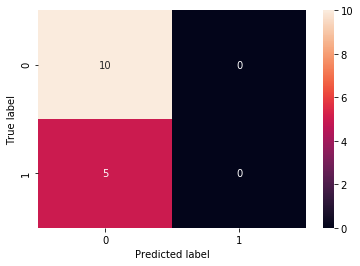

In [31]:

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel(...)
plt.ylabel(...)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()



# ROC curves

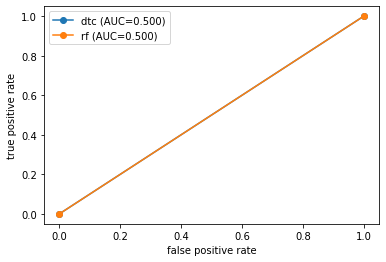

In [32]:
# I build ROC curve to see false positive rate, true positive rate of Decision Tree model and random forest model
classifiers = {
    
    'dtc': dtc,
    'rf': rf_model

}

for name, clf in classifiers.items():
    y_pred = clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresh = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, 'o-', label=f"{name} (AUC={auc:.3f})")

plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()


In [33]:
roc_auc_score(y_test, y_pred_rfc)

0.5

# Interpretation

In [22]:
# To look the features importance
X_train_, X_test_, y_train_, y_test_ = train_test_split(simplified_df,
                                                    data['tomato_price'],
                                                    random_state=50)
gsv = GridSearchCV(rf_model, {"max_depth": [10, 15, 20, 30],
                             "min_samples_split": [.005, .01, .05]}, 
                  n_jobs=-1, cv=5, scoring="balanced_accuracy")

gsv.fit(X_train_, y_train_)
gsv.best_estimator_.predict(X_train_)
importances = pd.DataFrame({
    'feature':  X_train_.columns,
    'importance': gsv.best_estimator_.feature_importances_
})
importances.sort_values('importance', ascending=False)
importances

,feature,importance
0,temperature_max,0.204920
1,temperature_min,0.100167
2,humidity,0.120930
3,precip_intensity,0.077928
4,precip_intensity_max,0.037703
5,pressure,0.051726
6,visibility,0.067458
7,wind_speed,0.052017
8,oil_price,0.058905
9,lettuce_price,0.060395


We can see that the maximum temperature and the minimum temperature are the features that most affects the variation of price of tomato.